# Diplodatos Kaggle Competition

We present this peace of code to create the baseline for the competition, and as an example of how to deal with these kind of problems. The main goals are that you:

1. Learn
1. Try different models and see which one fits the best the given data
1. Get a higher score than the given one in the current baseline example
1. Try to get the highest score in the class :)

In [136]:
# Import the required packages
import os

import numpy as np
import pandas as pd
import xgboost as xgb
import scipy
import matplotlib.pyplot as plt

In [135]:
!pip install pandas
!pip install numpy
!pip install xgboost
!pip install matplotlib
!pip install scipy
!pip install scikit-learn

In [8]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv
Saving test.csv to test.csv


In [178]:
vanilla_train_df = pd.read_csv('/content/train.csv')
vanilla_test_df = pd.read_csv('/content/test.csv')

Read the *original* dataset...

In [10]:
vanilla_train_df.columns

Index(['TripType', 'VisitNumber', 'Weekday', 'Upc', 'ScanCount',
       'DepartmentDescription', 'FinelineNumber'],
      dtype='object')

**TripType** is the column that we should predict. That column is not present in the test set

In [11]:
vanilla_train_df.describe()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,453411.000000,453411.000000,4.505590e+05,453411.000000,450559.000000
mean,58.027039,95909.846115,3.075243e+10,1.108584,3727.366554
std,155.973370,55399.801147,9.163940e+10,0.707029,2779.958546
min,3.000000,5.000000,8.340000e+02,-10.000000,0.000000
25%,27.000000,49390.000000,3.400004e+09,1.000000,1404.000000
50%,39.000000,96781.000000,7.056082e+09,1.000000,3352.000000
75%,40.000000,143930.000000,3.013201e+10,1.000000,5501.000000
max,999.000000,191347.000000,9.789707e+11,71.000000,9998.000000


In [12]:
vanilla_train_df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,8,9,Friday,1.070081e+09,1,IMPULSE MERCHANDISE,115.0
2,8,9,Friday,3.107000e+03,1,PRODUCE,103.0
3,8,9,Friday,4.011000e+03,1,PRODUCE,5501.0
4,8,10,Friday,6.414410e+09,1,DSD GROCERY,2008.0


Looking into the columns values...

In [13]:
set(vanilla_train_df.Weekday)

{'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'}

In [14]:
set(vanilla_train_df.DepartmentDescription)

{'1-HR PHOTO',
 'ACCESSORIES',
 'AUTOMOTIVE',
 'BAKERY',
 'BATH AND SHOWER',
 'BEAUTY',
 'BEDDING',
 'BOOKS AND MAGAZINES',
 'BOYS WEAR',
 'BRAS & SHAPEWEAR',
 'CAMERAS AND SUPPLIES',
 'CANDY, TOBACCO, COOKIES',
 'CELEBRATION',
 'COMM BREAD',
 'CONCEPT STORES',
 'COOK AND DINE',
 'DAIRY',
 'DSD GROCERY',
 'ELECTRONICS',
 'FABRICS AND CRAFTS',
 'FINANCIAL SERVICES',
 'FROZEN FOODS',
 'FURNITURE',
 'GIRLS WEAR, 4-6X  AND 7-14',
 'GROCERY DRY GOODS',
 'HARDWARE',
 'HEALTH AND BEAUTY AIDS',
 'HOME DECOR',
 'HOME MANAGEMENT',
 'HORTICULTURE AND ACCESS',
 'HOUSEHOLD CHEMICALS/SUPP',
 'HOUSEHOLD PAPER GOODS',
 'IMPULSE MERCHANDISE',
 'INFANT APPAREL',
 'INFANT CONSUMABLE HARDLINES',
 'JEWELRY AND SUNGLASSES',
 'LADIES SOCKS',
 'LADIESWEAR',
 'LARGE HOUSEHOLD GOODS',
 'LAWN AND GARDEN',
 'LIQUOR,WINE,BEER',
 'MEAT - FRESH & FROZEN',
 'MEDIA AND GAMING',
 'MENS WEAR',
 'MENSWEAR',
 'OFFICE SUPPLIES',
 'OPTICAL - FRAMES',
 'OPTICAL - LENSES',
 'OTHER DEPARTMENTS',
 'PAINT AND ACCESSORIES',
 'PER

There are `nan`s in the column, let us find them...

In [15]:
vanilla_train_df[vanilla_train_df.DepartmentDescription.isna()]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
739,999,484,Friday,NaN,-2,NaN,NaN
740,999,484,Friday,NaN,-2,NaN,NaN
1292,32,845,Friday,NaN,1,NaN,NaN
1293,32,845,Friday,NaN,1,NaN,NaN
1577,40,1004,Friday,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...
449840,40,190133,Sunday,NaN,1,NaN,NaN
450036,999,190182,Sunday,NaN,-1,NaN,NaN
450163,40,190230,Sunday,NaN,1,NaN,NaN
450361,39,190309,Sunday,NaN,1,NaN,NaN


When the description is NaN, then the Upc and FinelineNumber are both NaN?

In [17]:
(vanilla_train_df.DepartmentDescription.isna().sum(),
 (vanilla_train_df.DepartmentDescription.isna() & vanilla_train_df.Upc.isna() & vanilla_train_df.FinelineNumber.isna()).sum())

(972, 972)

In [18]:
vanilla_train_df[vanilla_train_df.Upc.isna()]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
739,999,484,Friday,NaN,-2,NaN,NaN
740,999,484,Friday,NaN,-2,NaN,NaN
900,5,585,Friday,NaN,1,PHARMACY RX,NaN
944,5,619,Friday,NaN,1,PHARMACY RX,NaN
945,5,619,Friday,NaN,1,PHARMACY RX,NaN
...,...,...,...,...,...,...,...
449840,40,190133,Sunday,NaN,1,NaN,NaN
450036,999,190182,Sunday,NaN,-1,NaN,NaN
450163,40,190230,Sunday,NaN,1,NaN,NaN
450361,39,190309,Sunday,NaN,1,NaN,NaN


But it may be the case that Upc is NaN but not the description...

In [19]:
(vanilla_train_df.Upc.isna().sum(),
 vanilla_train_df.FinelineNumber.isna().sum(),
 (vanilla_train_df.FinelineNumber.isna() & vanilla_train_df.Upc.isna()).sum())

(2852, 2852, 2852)

Upc and FinelineNumber are both NaN at the same time

Our last step in this analysis is to see how balanced is the data...

In [20]:
bins = set(vanilla_train_df.TripType)

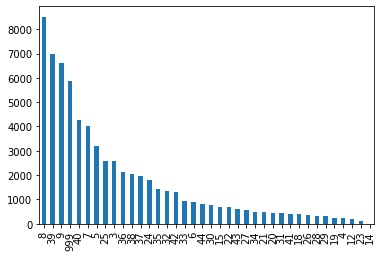

In [ ]:
# to count the TripType values, we have to group the visits by VisitNumber
vanilla_train_df.groupby("VisitNumber").TripType.mean().value_counts().plot(kind='bar')

**Unbalanced!!!**

Create a function to load the datasets.

**Some important decisions made here**:
1. We will use one hot encoding for Weekday and DepartmentDescription. All transformations are applied to the training and testing datasets...
1. We are handling NaN's as another category. This may not be the best approach.
1. We may have multiple records for one single visit and the goal is to classify all those records the exact same way. Therefore, we will prepare the data in a way that all the information for a visit is in the same record.
1. Based on the last bullet, we will count the DepartmentDescription for all items acquired in the same visit.
1. We drop the Upc and FinelineNumber to simplify the process. You may use it as they have a lot of information (may be using one-hot encoding for them as well)

The following operations will be performed in a function. Anyway, we present them here so that we can see them in action:

First, we drop the columns. We include TripType as we are going to treat it differently:

In [21]:
df = vanilla_train_df.drop(["Upc", "FinelineNumber", "TripType"], axis=1)

In [22]:
df

,VisitNumber,Weekday,ScanCount,DepartmentDescription
0,5,Friday,-1,FINANCIAL SERVICES
1,9,Friday,1,IMPULSE MERCHANDISE
2,9,Friday,1,PRODUCE
3,9,Friday,1,PRODUCE
4,10,Friday,1,DSD GROCERY
...,...,...,...,...
453406,191344,Sunday,1,BEAUTY
453407,191344,Sunday,1,WIRELESS
453408,191344,Sunday,1,BEAUTY
453409,191347,Sunday,1,DAIRY


Now, we create the dummy columns

In [23]:
df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)

In [24]:
df

,VisitNumber,Weekday,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,DepartmentDescription_BRAS & SHAPEWEAR,DepartmentDescription_CAMERAS AND SUPPLIES,"DepartmentDescription_CANDY, TOBACCO, COOKIES",DepartmentDescription_CELEBRATION,DepartmentDescription_COMM BREAD,DepartmentDescription_CONCEPT STORES,DepartmentDescription_COOK AND DINE,DepartmentDescription_DAIRY,DepartmentDescription_DSD GROCERY,DepartmentDescription_ELECTRONICS,DepartmentDescription_FABRICS AND CRAFTS,DepartmentDescription_FINANCIAL SERVICES,DepartmentDescription_FROZEN FOODS,DepartmentDescription_FURNITURE,"DepartmentDescription_GIRLS WEAR, 4-6X AND 7-14",DepartmentDescription_GROCERY DRY GOODS,DepartmentDescription_HARDWARE,DepartmentDescription_HEALTH AND BEAUTY AIDS,DepartmentDescription_HOME DECOR,DepartmentDescription_HOME MANAGEMENT,DepartmentDescription_HORTICULTURE AND ACCESS,DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP,DepartmentDescription_HOUSEHOLD PAPER GOODS,DepartmentDescription_IMPULSE MERCHANDISE,DepartmentDescription_INFANT APPAREL,DepartmentDescription_INFANT CONSUMABLE HARDLINES,DepartmentDescription_JEWELRY AND SUNGLASSES,DepartmentDescription_LADIES SOCKS,DepartmentDescription_LADIESWEAR,DepartmentDescription_LARGE HOUSEHOLD GOODS,DepartmentDescription_LAWN AND GARDEN,"DepartmentDescription_LIQUOR,WINE,BEER",DepartmentDescription_MEAT - FRESH & FROZEN,DepartmentDescription_MEDIA AND GAMING,DepartmentDescription_MENS WEAR,DepartmentDescription_MENSWEAR,DepartmentDescription_OFFICE SUPPLIES,DepartmentDescription_OPTICAL - FRAMES,DepartmentDescription_OPTICAL - LENSES,DepartmentDescription_OTHER DEPARTMENTS,DepartmentDescription_PAINT AND ACCESSORIES,DepartmentDescription_PERSONAL CARE,DepartmentDescription_PETS AND SUPPLIES,DepartmentDescription_PHARMACY OTC,DepartmentDescription_PHARMACY RX,DepartmentDescription_PLAYERS AND ELECTRONICS,DepartmentDescription_PLUS AND MATERNITY,DepartmentDescription_PRE PACKED DELI,DepartmentDescription_PRODUCE,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan
0,5,Friday,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,9,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,10,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453406,191344,Sunday,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
453407,191344,Sunday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
453408,191344,Sunday,1,0,0,0,0,0

Now, we group by the VisitNumber and Weekday (they should be the same), and add all values for ScanCount, and the one-hot encoding of DepartmentDescriptioin

In [25]:
df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()

In [26]:
df

,VisitNumber,Weekday,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,DepartmentDescription_BRAS & SHAPEWEAR,DepartmentDescription_CAMERAS AND SUPPLIES,"DepartmentDescription_CANDY, TOBACCO, COOKIES",DepartmentDescription_CELEBRATION,DepartmentDescription_COMM BREAD,DepartmentDescription_CONCEPT STORES,DepartmentDescription_COOK AND DINE,DepartmentDescription_DAIRY,DepartmentDescription_DSD GROCERY,DepartmentDescription_ELECTRONICS,DepartmentDescription_FABRICS AND CRAFTS,DepartmentDescription_FINANCIAL SERVICES,DepartmentDescription_FROZEN FOODS,DepartmentDescription_FURNITURE,"DepartmentDescription_GIRLS WEAR, 4-6X AND 7-14",DepartmentDescription_GROCERY DRY GOODS,DepartmentDescription_HARDWARE,DepartmentDescription_HEALTH AND BEAUTY AIDS,DepartmentDescription_HOME DECOR,DepartmentDescription_HOME MANAGEMENT,DepartmentDescription_HORTICULTURE AND ACCESS,DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP,DepartmentDescription_HOUSEHOLD PAPER GOODS,DepartmentDescription_IMPULSE MERCHANDISE,DepartmentDescription_INFANT APPAREL,DepartmentDescription_INFANT CONSUMABLE HARDLINES,DepartmentDescription_JEWELRY AND SUNGLASSES,DepartmentDescription_LADIES SOCKS,DepartmentDescription_LADIESWEAR,DepartmentDescription_LARGE HOUSEHOLD GOODS,DepartmentDescription_LAWN AND GARDEN,"DepartmentDescription_LIQUOR,WINE,BEER",DepartmentDescription_MEAT - FRESH & FROZEN,DepartmentDescription_MEDIA AND GAMING,DepartmentDescription_MENS WEAR,DepartmentDescription_MENSWEAR,DepartmentDescription_OFFICE SUPPLIES,DepartmentDescription_OPTICAL - FRAMES,DepartmentDescription_OPTICAL - LENSES,DepartmentDescription_OTHER DEPARTMENTS,DepartmentDescription_PAINT AND ACCESSORIES,DepartmentDescription_PERSONAL CARE,DepartmentDescription_PETS AND SUPPLIES,DepartmentDescription_PHARMACY OTC,DepartmentDescription_PHARMACY RX,DepartmentDescription_PLAYERS AND ELECTRONICS,DepartmentDescription_PLUS AND MATERNITY,DepartmentDescription_PRE PACKED DELI,DepartmentDescription_PRODUCE,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan
0,5,Friday,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,Friday,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
2,10,Friday,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,11,Friday,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,Friday,7,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67024,191329,Sunday,20,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,7,2,0,0,0,1,1,0,0,0,0,0,1,4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67025,191337,Sunday,27,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,3,0,0,0,2,0,0,10,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
67026,191343,Sunday,9,0,0,0,0

In [177]:
days = {
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
    "Sunday": 7
}

custom_trip_types = {
    3:0, 4:1, 5:2, 6:3, 7:4, 8:5, 9:6, 12:7, 14:8, 15:9, 18:10,
    19:11, 20:12, 21:13, 22:14, 23:15, 24:16, 25:17, 26:18, 27:19,
    28:20, 29:21, 30:22, 31:23, 32:24, 33:25, 34:26, 35:27, 36:28,
    37:29, 38:30, 39:31, 40:32, 41:33, 42:34, 43:35, 44:36, 999:37
}

def get_original_trip_types(transformed_trip_types):
    original_tt = {
        custom_trip_types[k]: k for k in custom_trip_types
    }
    return transformed_trip_types.map(original_tt)

def transform_data(vanilla_train, vanilla_test):
    train_df = vanilla_train
    test_df = vanilla_test
    # set if train or test
    train_df['is_train_set'] = 1
    test_df['is_train_set'] = 0

    # we  get the TripType for the train set. To do that, we group by
    # VisitNumber and then we get the max (or min or avg)
    y = train_df.groupby(
        ["VisitNumber", "Weekday"], as_index=False).max().TripType
    # parse original trip types to our cool trip types
    y = y.map(custom_trip_types)

    # drop TripType because test_df does not have it
    train_df = train_df.drop("TripType", axis=1)
    data = pd.concat([train_df, test_df])

    # Get dummies for departments
    dummies = pd.get_dummies(data.DepartmentDescription)
    data[dummies.columns] = dummies
    data['Weekday'] = data['Weekday'].map(days)

    data_dummies = data.iloc[:,7:]
    data_dummies = data_dummies.apply(lambda x: x*data["ScanCount"])
    data_dummies = data_dummies.replace(-0,0)

    # Get if element is returned or not
    data.loc[data.ScanCount < 0, 'Return'] = 1
    data.loc[data.Return != 1, 'Return'] = 0

    # Get useful columns and change ScanCount for NumItems
    data = data[[
        "VisitNumber", "Weekday", "ScanCount", "Return", "is_train_set"]]
    data = data.rename(columns={"ScanCount":"NumItems"})
    data = pd.concat([data, data_dummies], axis=1)

    # Set all features and a method to get the grouping method to use in each
    # of the features. (np.sum if is department feature and np.max if not.
    non_dept_features = ['Weekday', 'NumItems', 'Return', 'is_train_set', 'VisitNumber']
    features = non_dept_features + list(dummies.columns)
    get_grouped_method = lambda f : np.max if f in non_dept_features else np.sum

    # Get all the features and the group method used in each one in a nice dict
    group_methods = {k: get_grouped_method(k) for k in features}
    # Group them once and for all using VisitNumber
    grouped = data.groupby("VisitNumber")
    grouped = grouped.agg(group_methods)

    data = grouped[features]

    # get train and test back
    train_df = data[data.is_train_set != 0]
    test_df = data[data.is_train_set == 0]

    res_train_df = train_df.drop(["is_train_set"], axis=1)
    res_test_df = test_df.drop(["is_train_set"], axis=1)

    res_train_df['TripType'] = y

    return res_train_df, res_test_df

def transform_data_train(vanilla_train):
    data = vanilla_train

    # Get dummies for departments
    dummies = pd.get_dummies(data.DepartmentDescription)
    data[dummies.columns] = dummies
    data['Weekday'] = data['Weekday'].map(days)

    data_dummies = data.iloc[:,7:]
    data_dummies = data_dummies.apply(lambda x: x*data["ScanCount"])
    data_dummies = data_dummies.replace(-0,0)

    # Get if element is returned or not
    data.loc[data.ScanCount < 0, 'Return'] = 1
    data.loc[data.Return != 1, 'Return'] = 0

    # Get useful columns and change ScanCount for NumItems
    data = data[[
        "TripType", "VisitNumber", "Weekday", "ScanCount", "Return"]]
    data = data.rename(columns={"ScanCount":"NumItems"})
    data = pd.concat([data, data_dummies], axis=1)

    # Set all features and a method to get the grouping method to use in each
    # of the features. (np.sum if is department feature and np.max if not.
    non_dept_features = ['TripType', 'Weekday', 'NumItems', 'Return']
    features = non_dept_features + list(dummies.columns)
    features.remove('1-HR PHOTO')
    get_grouped_method = lambda f : np.max if f in non_dept_features else np.sum

    # Get all the features and the group method used in each one in a nice dict
    group_methods = {k: get_grouped_method(k) for k in features}
    # Group them once and for all using VisitNumber
    grouped = data.groupby("VisitNumber")
    grouped = grouped.agg(group_methods)

    data = grouped[features]
    data["TripType"] = data["TripType"].map(custom_trip_types)

    return data

def transform_data_test(vanilla_test):
    data = vanilla_test

    # Get dummies for departments
    dummies = pd.get_dummies(data.DepartmentDescription)
    data[dummies.columns] = dummies
    data['Weekday'] = data['Weekday'].map(days)

    data_dummies = data.iloc[:,7:]
    data_dummies = data_dummies.apply(lambda x: x*data["ScanCount"])
    data_dummies = data_dummies.replace(-0,0)

    # Get if element is returned or not
    data.loc[data.ScanCount < 0, 'Return'] = 1
    data.loc[data.Return != 1, 'Return'] = 0

    # Get useful columns and change ScanCount for NumItems
    data = data[[
        "VisitNumber", "Weekday", "ScanCount", "Return"]]
    data = data.rename(columns={"ScanCount":"NumItems"})
    data = pd.concat([data, data_dummies], axis=1)

    # Set all features and a method to get the grouping method to use in each
    # of the features. (np.sum if is department feature and np.max if not.
    non_dept_features = ['Weekday', 'NumItems', 'Return']
    features = non_dept_features + list(dummies.columns)
    features.remove('1-HR PHOTO')
    get_grouped_method = lambda f : np.max if f in non_dept_features else np.sum

    # Get all the features and the group method used in each one in a nice dict
    group_methods = {k: get_grouped_method(k) for k in features}
    # Group them once and for all using VisitNumber
    grouped = data.groupby("VisitNumber")
    grouped = grouped.agg(group_methods)

    data = grouped[features]

    return data

Load the data...

In [180]:
res_train_df = transform_data_train(vanilla_train_df)
res_test_df = transform_data_test(vanilla_test_df)

Create the model and evaluate it

In [181]:
# split training dataset into train and "validation" 
# (we won't be using validation set in this example, because of the cross-validation;
# but it could be useful for you depending on your approach)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(res_train_df, test_size = .4)

In [163]:
real_test_matrix = scipy.sparse.csr_matrix(res_test_df.values)

In [182]:
res_train_df.columns

Index(['TripType', 'Weekday', 'NumItems', 'Return', 'ACCESSORIES',
       'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY', 'BEDDING',
       'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR',
       'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION',
       'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
       'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
       'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
       'GROCERY DRY GOODS', 'HARDWARE', 'HEALTH AND BEAUTY AIDS', 'HOME DECOR',
       'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
       'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
       'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES',
       'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR',
       'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER',
       'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING', 'MENS WEAR', 'MENSWEAR',
       'OFFICE SUPPLIES', 'OPTI

In [189]:
[x for x in res_train_df.columns if x not in res_test_df.columns]

['TripType', 'HEALTH AND BEAUTY AIDS']

In [195]:
train_matrix = xgb.DMatrix(
  np.asarray(train_df.drop(["TripType", "HEALTH AND BEAUTY AIDS"], axis=1)),
  label = np.asarray(train_df.TripType)
)
test_matrix = xgb.DMatrix(
  np.asarray(test_df.drop(["TripType", "HEALTH AND BEAUTY AIDS"], axis=1)),
  label = np.asarray(test_df.TripType)
)
real_test_matrix = xgb.DMatrix(np.asarray(res_test_df))

Setting Paramaters

In [196]:
num_round = 200
param = {'objective': 'multi:softprob', 'num_class':38, 
     'eval_metric': 'mlogloss', "max_delta_step": 5}
watchlist = [(train_matrix,'train'), (test_matrix, 'eval')]

In [76]:
len(train_df.columns)

72

Training the Model

In [197]:
xgb_model = xgb.train(param, train_matrix, num_round, watchlist, 
            early_stopping_rounds=3)

[0]	train-mlogloss:2.54521	eval-mlogloss:2.58438
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:2.05731	eval-mlogloss:2.12154
[2]	train-mlogloss:1.81587	eval-mlogloss:1.8961
[3]	train-mlogloss:1.64875	eval-mlogloss:1.74229
[4]	train-mlogloss:1.52512	eval-mlogloss:1.63035
[5]	train-mlogloss:1.42628	eval-mlogloss:1.54097
[6]	train-mlogloss:1.34718	eval-mlogloss:1.47169
[7]	train-mlogloss:1.28237	eval-mlogloss:1.41543
[8]	train-mlogloss:1.22748	eval-mlogloss:1.36895
[9]	train-mlogloss:1.18134	eval-mlogloss:1.33043
[10]	train-mlogloss:1.14222	eval-mlogloss:1.29826
[11]	train-mlogloss:1.10768	eval-mlogloss:1.27055
[12]	train-mlogloss:1.07747	eval-mlogloss:1.24739
[13]	train-mlogloss:1.05164	eval-mlogloss:1.22765
[14]	train-mlogloss:1.0273	eval-mlogloss:1.20921
[15]	train-mlogloss:1.0053	eval-mlogloss:1.19367
[16]	train-mlogloss:0.985949	eval-mlogloss:1.18017
[17]	train-m

**And finally**, we predict the unknown label for the testing set

In [198]:
test_predictions = xgb_model.predict(real_test_matrix)

In [107]:
test_predictions

array([[1.4184633e-05, 1.3422781e-06, 1.4993150e-05, ..., 2.0443567e-03,
        2.8163963e-03, 2.2001911e-04],
       [3.8166592e-05, 7.0963964e-05, 1.0793380e-03, ..., 5.3004329e-03,
        1.0899379e-03, 2.0088707e-03],
       [9.4510051e-07, 2.5307583e-07, 2.8221759e-06, ..., 4.2572719e-06,
        1.3535009e-06, 9.9843568e-01],
       ...,
       [9.3157258e-05, 1.6360829e-05, 8.2214443e-05, ..., 1.8631649e-03,
        2.8906082e-04, 4.6232569e-01],
       [3.3485046e-06, 1.5718353e-05, 2.4492649e-04, ..., 2.7924399e-03,
        5.2529399e-04, 2.8731639e-04],
       [6.0298680e-05, 1.7364413e-05, 2.1979236e-04, ..., 1.6829364e-03,
        1.5464524e-03, 2.4846864e-01]], dtype=float32)

The last thing we do is generating a file that should be *submitted* on kaggle

In [199]:
def predictions_to_csv(test_predictions):
    test_predictions = pd.DataFrame(test_predictions)
    test_indexes = test_predictions.index
    test_predictions = test_predictions.rename(columns = {0:3, 1: 4, 2: 5, 3: 6, 
                4: 7, 5: 8, 6: 9, 7: 12, 8: 14, 
                9: 15, 10: 18, 11: 19, 12: 20, 13: 21,
                14: 22, 15: 23, 16: 24, 17: 25, 18: 26, 
                19: 27, 20: 28, 21: 29, 22: 30, 23: 31, 
                24: 32, 25: 33, 26: 34, 27: 35, 28: 36, 
                29: 37, 30: 38, 31: 39, 32: 40, 33: 41, 
                34: 42, 35: 43, 36: 44, 37: 999})
    test_predictions.insert(0, 'VisitNumber', test_indexes)
    test_predictions['TripType'] = test_predictions.drop('VisitNumber', axis=1).idxmax(axis=1)
    test_predictions
    return test_predictions[['VisitNumber', 'TripType']].to_csv("/content/submission.csv", index=False)

In [200]:
predictions_to_csv(test_predictions)